In [1]:
#libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import imdb
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import KFold
from sklearn.model_selection import KFold
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



# Mining Massive Data (SS2024)
## Programming Assignment 2 (Large-scale SVM Training)

## Dataloading

in the next few operations all the datasources are loaded 

In [2]:
# helper functions
def load_dataset(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # print last 10 values of y
    #print("Last 10 values of y: ", y[-10:])
    
    # print the shape of X and y
    print("X shape: ", X.shape)
    print("y shape: ", y.shape)
    return X, y

def load_imdb_dataset_with_dropout(num_samples=100, max_length=500, dropout_prob=0.5):
    # Load the dataset
    (x_train, y_train), (x_test, y_test) = imdb.load_data(
        path="imdb.npz", num_words=None, skip_top=0, maxlen=None,
        seed=113, start_char=1, oov_char=2, index_from=3
    )

    # Cut the dataset to the specified number of samples
    x_train = x_train[:num_samples]
    y_train = y_train[:num_samples]

    # Pad the sequences to have uniform length
    x_train = pad_sequences(x_train, maxlen=max_length)
    y_train = np.array(y_train)

    # Print the shape of the dataset
    print("Shape of x_train:", x_train.shape)

    # Apply feature dropout
    # Generate a random mask of the same shape as x_train
    mask = np.random.rand(*x_train.shape) < (1 - dropout_prob)
    # Apply the mask to x_train to drop some features
    x_train = x_train * mask
    
    
def load_imdb_dataset(num_samples=100, max_length=500):
    # Load the dataset
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz", num_words=None, skip_top=0, maxlen=None, seed=113, start_char=1, oov_char=2, index_from=3)
    # Print the last 10 values of y
    #print("Last 10 values of y: ", y_train[-10:])
    # print first 10 values of X
    #print("First 10 values of X: ", x_train[:10])
    # cut x and y into num samples
    x_train = x_train[:num_samples]
    y_train = y_train[:num_samples]
    # create np array of both 
    x_train = pad_sequences(x_train, maxlen=max_length)
    print("Shape of x_train: ", x_train.shape)
    y_train = np.array(y_train)
    return x_train, y_train

### Toydata

X shape:  (200, 2)
y shape:  (200,)


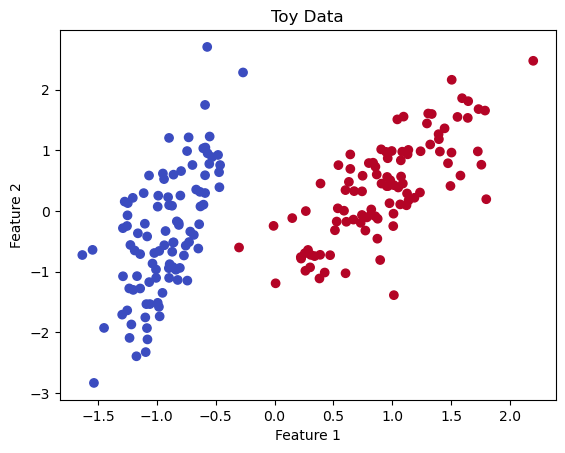

In [3]:
#plot X and y values
X_tiny, y_tiny = load_dataset("toydata_tiny.csv")
plt.scatter(X_tiny[:, 0], X_tiny[:, 1], c=y_tiny, cmap='coolwarm')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Toy Data')
plt.show()

X shape:  (200000, 8)
y shape:  (200000,)


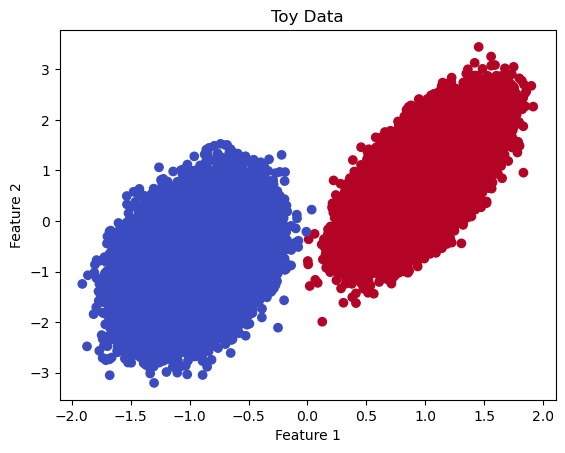

In [4]:
X_large, y_large = load_dataset("toydata_large.csv")
plt.scatter(X_large[:, 2], X_large[:, 3], c=y_large, cmap='coolwarm')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Toy Data')
plt.show()

### Imdbdata

Shape of x_train:  (1000, 2)


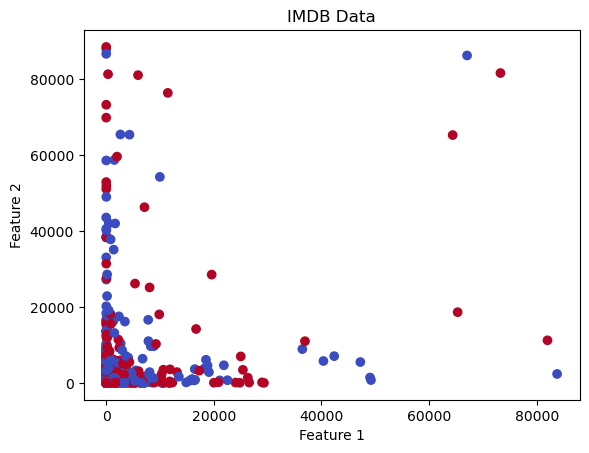

In [5]:
# Usage
X_imdb, y_imdb = load_imdb_dataset(1000,2)

# plot the features of X to y value (0/1)
plt.scatter(X_imdb[:, 0], X_imdb[:, 1], c=y_imdb, cmap='coolwarm')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('IMDB Data')
plt.show()

### Preprocessing(optional)

In [6]:
'''
from keras.preprocessing.text import Tokenizer
def tfidf_transform(x_train, num_features=10000):
    # Initialize tokenizer with a given number of words
    tokenizer = Tokenizer(num_words=num_features)
    tokenizer.fit_on_sequences(x_train)
    
    # Convert sequences to text list
    x_train_text = [" ".join(map(str, sequence)) for sequence in x_train]
    
    # Apply TF-IDF transformation
    tfidf = TfidfVectorizer(max_features=num_features, dtype=np.float32)
    x_train_tfidf = tfidf.fit_transform(x_train_text)
    
    return x_train_tfidf.toarray()


from sklearn.feature_selection import SelectKBest, chi2

def select_features(X, y, k=500):
    # Apply Chi-squared test to select the top k features
    chi2_selector = SelectKBest(chi2, k=k)
    X_kbest_features = chi2_selector.fit_transform(X, y)
    return X_kbest_features

def apply_lda(X, y):
    lda = LinearDiscriminantAnalysis(n_components=1)
    X_lda = lda.fit_transform(X, y)
    return X_lda


import matplotlib.pyplot as plt

def plot_data(X, y):
    plt.figure(figsize=(8, 4))
    plt.scatter(X[:, 0], np.zeros_like(X[:, 0]), c=y, cmap='coolwarm', alpha=0.5)
    plt.colorbar()  # Show color scale
    plt.xlabel('Projected Feature')
    plt.ylabel('Dummy Zero Axis')
    plt.title('IMDB Data Projection via LDA')
    plt.show()



def load_and_preprocess_imdb(num_samples=1000, max_length=500, num_features=10000, top_k_features=500):
    # Load the dataset
    (x_train, y_train), _ = imdb.load_data(num_words=num_features)
    x_train = x_train[:num_samples]
    y_train = y_train[:num_samples]
    
    # Pad sequences
    x_train_padded = pad_sequences(x_train, maxlen=max_length)
    
    # Convert sequences to a list of strings
    tokenizer = Tokenizer(num_words=num_features)
    tokenizer.fit_on_sequences(x_train_padded)
    x_train_text = [" ".join(map(str, seq)) for seq in x_train_padded]

    # Apply TF-IDF transformation
    tfidf = TfidfVectorizer(max_features=num_features, dtype=np.float32)
    x_train_tfidf = tfidf.fit_transform(x_train_text)

    # Convert TF-IDF sparse output to a dense array
    x_train_tfidf_dense = x_train_tfidf.toarray()

    # Select top k features
    selector = SelectKBest(chi2, k=top_k_features)
    x_train_kbest = selector.fit_transform(x_train_tfidf_dense, y_train)

    # Apply LDA
    lda = LinearDiscriminantAnalysis(n_components=1)
    x_train_lda = lda.fit_transform(x_train_kbest, y_train)
    
    return x_train_lda, y_train
# Load and preprocess the data
X_processed, y_processed = load_and_preprocess_imdb()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.25, random_state=42)

# Initialize and train the SVM model with a linear kernel
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the SVM model on the test set: {accuracy:.2f}")

# Optional: Visualization of decision boundary
plt.scatter(X_processed[:, 0], np.zeros_like(X_processed[:, 0]), c=y_processed, cmap='coolwarm', alpha=0.5)
plt.scatter(X_test[:, 0], np.zeros_like(X_test[:, 0]), c=y_pred, marker='x')
plt.colorbar()  # Show color scale
plt.xlabel('Projected Feature by LDA')
plt.ylabel('Dummy Zero Axis')
plt.title('IMDB Data Projection and SVM Decision Boundary')
plt.show()'''

'\nfrom keras.preprocessing.text import Tokenizer\ndef tfidf_transform(x_train, num_features=10000):\n    # Initialize tokenizer with a given number of words\n    tokenizer = Tokenizer(num_words=num_features)\n    tokenizer.fit_on_sequences(x_train)\n    \n    # Convert sequences to text list\n    x_train_text = [" ".join(map(str, sequence)) for sequence in x_train]\n    \n    # Apply TF-IDF transformation\n    tfidf = TfidfVectorizer(max_features=num_features, dtype=np.float32)\n    x_train_tfidf = tfidf.fit_transform(x_train_text)\n    \n    return x_train_tfidf.toarray()\n\n\nfrom sklearn.feature_selection import SelectKBest, chi2\n\ndef select_features(X, y, k=500):\n    # Apply Chi-squared test to select the top k features\n    chi2_selector = SelectKBest(chi2, k=k)\n    X_kbest_features = chi2_selector.fit_transform(X, y)\n    return X_kbest_features\n\ndef apply_lda(X, y):\n    lda = LinearDiscriminantAnalysis(n_components=1)\n    X_lda = lda.fit_transform(X, y)\n    return X_ld

## Evaluation methods
These methods are basic methods for the svms and are used from all implementations

In [7]:
def predict(X, w):
    """
    Predict using the trained weights of the SVM.
    - X: feature matrix
    - w: weight vector
    """
    return np.sign(np.dot(X, w))

def predict_rff(X, w, omega, b):
    """
    Predict with the SVM trained on RFF-transformed data.
    - X: original feature matrix
    - w: trained weight vector
    - omega: frequencies matrix used for RFF
    - b: biases used for RFF
    """
    X_transformed = rff_gaussian_transform(X, omega, b)
    return np.sign(np.dot(X_transformed, w))

def accuracy(y_true, y_pred):
    """
    Calculate the accuracy of predictions.
    - y_true: true labels
    - y_pred: predicted labels
    """
    return np.mean(y_true == y_pred)

## Parameter evaluation

These functions take a couple of models and the datasets to find the best ones

In [8]:


import numpy as np
from sklearn.model_selection import KFold
from tqdm import tqdm

def evaluate_models_k_test(datasets, model_types, params):
    """
    Evaluates different model types on datasets with various parameter combinations using 5-fold cross-validation.

    Args:
        datasets: A dictionary with dataset names as keys and (X, y) tuples as values.
        model_types: A list of strings denoting the types of models to evaluate.
        params: A dictionary with model types as keys and lists of parameter combinations as values.
    """
    results = {}

    # Iterate over each dataset
    for name, (X, y) in datasets.items():
        results[name] = {}
        if name == 'imdb':
            y = np.where(y == 0, -1, 1)  # Convert labels

        for model_type in model_types:
            best_accuracy = 0
            best_params = {}

            param_combinations = params[model_type]
            progress_bar = tqdm(param_combinations, desc=f"Processing {name} - {model_type}")

            for param_comb in progress_bar:
                # Initialize KFold with 5 splits
                kf = KFold(n_splits=5)

                fold_accuracies = []

                for train_index, test_index in kf.split(X):
                    # Split the data into training and testing sets
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    # Train model
                    if model_type == 'linear':
                        w = train_svm_linear(X_train, y_train, **param_comb)
                        predictions = predict(X_test, w)
                    elif model_type == 'adagrad':
                        w = train_svm_adagrad(X_train, y_train, **param_comb)
                        predictions = predict(X_test, w)
                    elif model_type == 'rff':
                        w, omega, b = train_svm_rff(X_train, y_train, **param_comb)
                        predictions = predict_rff(X_test, w, omega, b)

                    acc = accuracy(y_test, predictions)
                    fold_accuracies.append(acc)

                # Average accuracy over all folds
                avg_acc = np.mean(fold_accuracies)
                progress_bar.set_postfix_str(f"Acc: {avg_acc:.4f}")

                # Update if better
                if avg_acc > best_accuracy:
                    best_accuracy = avg_acc
                    best_params = param_comb

            results[name][model_type] = {
                'Best Parameters': best_params,
                'Best Accuracy': best_accuracy
            }

    return results

from tqdm import tqdm
import numpy as np

def evaluate_models(datasets, model_types, params):
    """
    Evaluates different model types on datasets with various parameter combinations.

    Args:
        datasets: A dictionary with dataset names as keys and (X, y) tuples as values.
        model_types: A list of strings denoting the types of models to evaluate.
        params: A dictionary with model types as keys and lists of parameter combinations as values.
    """
    results = {}

    # Iterate over each dataset
    for name, (X, y) in datasets.items():
        results[name] = {}
        if name == 'IMDB':
            y = np.where(y == 0, -1, 1)  # Convert labels

        for model_type in model_types:
            best_accuracy = 0
            best_params = {}

            param_combinations = params[model_type]
            progress_bar = tqdm(param_combinations, desc=f"Processing {name} - {model_type}")

            for param_comb in progress_bar:
                # Train model
                if model_type == 'linear':
                    w = train_svm_linear(X, y, **param_comb)
                    predictions = predict(X, w)
                elif model_type == 'rff':
                    w, omega, b = train_svm_rff(X, y, **param_comb)
                    predictions = predict_rff(X, w, omega, b)

                # Evaluate accuracy
                avg_acc = accuracy(y, predictions)
                progress_bar.set_postfix_str(f"Acc: {avg_acc:.4f}")

                # Update if better
                if avg_acc > best_accuracy:
                    best_accuracy = avg_acc
                    best_params = param_comb

            results[name][model_type] = {
                'Best Parameters': best_params,
                'Best Accuracy': best_accuracy
            }

    return results




### Linear SVM Model

In [9]:
def svm_loss(W, X, y, C):
    distances = 1 - y * np.dot(X, W)
    hinge_loss = C * np.mean(np.maximum(0, distances))
    regularization_loss = 0.5 * np.dot(W, W)
    return regularization_loss + hinge_loss

def svm_gradient(W, X_batch, y_batch, C):
    distances = 1 - y_batch * np.dot(X_batch, W)
    dw = np.zeros_like(W)
    for ind, d in enumerate(distances):
        if d > 0:
            # Only the misclassified points affect the gradient
            dw += C * (-y_batch[ind] * X_batch[ind])
    dw /= len(y_batch)  # Average over the batch
    dw += W  # Add gradient of the regularization term
    return dw

def train_svm_linear(X, y, batch_size=10, C=1.0, epochs=10, lr=0.01):
    w = np.random.randn(X.shape[1]) / np.sqrt(X.shape[1])  # Improved initialization
    n_batches = int(np.ceil(len(y) / batch_size))
    for epoch in range(epochs):
        perm = np.random.permutation(len(y))  # Shuffle the data
        for b in range(n_batches):
            start = b * batch_size
            end = min(start + batch_size, len(y))
            X_batch = X[perm[start:end]]
            y_batch = y[perm[start:end]]
            grad = svm_gradient(w, X_batch, y_batch, C)
            w -= lr * grad
        # Optionally, decrease learning rate gradually
        if (epoch + 1) % 100 == 0:
            lr /= 2
    return w

### Optimization using Adagrad

In [10]:
def train_svm_adagrad(X, y, batch_size=10, C=1.0, epochs=10, lr=0.01):
    """
    Train a linear SVM using AdaGrad optimization.
    - X: feature matrix
    - y: target vector
    - batch_size: size of the mini-batch
    - C: regularization strength
    - epochs: number of training epochs
    - lr: initial learning rate
    """
    w = np.zeros(X.shape[1])
    epsilon = 1e-8  # smoothing term to avoid division by zero
    gradient_accumulate = np.zeros(X.shape[1])
    n_batches = int(len(y) / batch_size)

    for epoch in range(epochs):
        for b in range(n_batches):
            start = b * batch_size
            end = start + batch_size
            X_batch = X[start:end]
            y_batch = y[start:end]
            grad = svm_gradient(w, X_batch, y_batch, C)
            gradient_accumulate += grad ** 2
            adjusted_lr = lr / (epsilon + np.sqrt(gradient_accumulate))
            w = w - adjusted_lr * grad
            
    return w

### Random Fourier Features

In [11]:
def rff_gaussian_transform(X, omega, b):
    """
    Apply the Random Fourier Features transformation to the dataset.
    - X: feature matrix
    - omega: frequencies matrix
    - b: bias terms
    """
    X_features = np.dot(X, omega) + b
    return np.cos(X_features)

def train_svm_rff(X, y,batch_size=10, gamma= 0.01, n_features=500, C=1.0, epochs=10, lr=0.01):
    """
    Train a SVM with RFF approximation for a Gaussian kernel.
    - X: feature matrix
    - y: target vector
    - gamma: parameter of Gaussian kernel
    - n_features: number of random features
    - C: regularization strength
    - epochs: number of training epochs
    - lr: learning rate
    """
    # Create Random Fourier Features transformation parameters
    omega = np.random.normal(scale=2*np.pi*gamma, size=(X.shape[1], n_features))
    b = np.random.uniform(0, 2*np.pi, size=n_features)

    # Transform training data
    X_transformed = rff_gaussian_transform(X, omega, b)
    w = train_svm_linear(X_transformed, y,batch_size, C=C, epochs=epochs, lr=lr)
    
    return w, omega, b


## Find best parameters
usasge of the find best parameter using K fold and normal apporach

In [12]:
# Required imports
import itertools

# Example usage
datasets = {
    'toydate_tiny': load_dataset("toydata_tiny.csv"),
    'toydata_large': load_dataset("toydata_large.csv"),
    'imdb': load_imdb_dataset(1000, 2)
}

model_types = ['linear', 'adagrad', 'rff']

# Defining parameter values
C_values = [0.1, 1.0, 10.0]
lr_values = [0.00001, 0.0001, 0.01, 0.1, 0.5, 1.0, 2]
batch_size_values = [10, 20, 50]
gamma_values = [0.001, 0.01, 0.1]
n_features_values = [100, 250, 500, 750, 1000, 2000]
epochs_values = [1, 5, 10, 20, 50]  # Added multiple values for epochs

# Creating parameter combinations for each model
params = {
    'linear': [
        {'C': C, 'epochs': epochs, 'lr': lr, 'batch_size': bs} 
        for C, epochs, lr, bs in itertools.product(C_values, epochs_values, lr_values, batch_size_values)
    ],
    'adagrad': [
        {'C': C, 'epochs': epochs, 'lr': lr, 'batch_size': bs} 
        for C, epochs, lr, bs in itertools.product(C_values, epochs_values, lr_values, batch_size_values)
    ],
    'rff': [
        {'C': C, 'epochs': epochs, 'lr': lr, 'batch_size': bs, 'gamma': g, 'n_features': nf} 
        for C, epochs, lr, bs, g, nf in itertools.product(C_values, epochs_values, lr_values, batch_size_values, gamma_values, n_features_values)
    ]
}

print(params)

results = evaluate_models_k_test(datasets, model_types, params)
print(results)


X shape:  (200, 2)
y shape:  (200,)
X shape:  (200000, 8)
y shape:  (200000,)
Shape of x_train:  (1000, 2)
{'linear': [{'C': 0.1, 'epochs': 1, 'lr': 1e-05, 'batch_size': 10}, {'C': 0.1, 'epochs': 1, 'lr': 1e-05, 'batch_size': 20}, {'C': 0.1, 'epochs': 1, 'lr': 1e-05, 'batch_size': 50}, {'C': 0.1, 'epochs': 1, 'lr': 0.0001, 'batch_size': 10}, {'C': 0.1, 'epochs': 1, 'lr': 0.0001, 'batch_size': 20}, {'C': 0.1, 'epochs': 1, 'lr': 0.0001, 'batch_size': 50}, {'C': 0.1, 'epochs': 1, 'lr': 0.01, 'batch_size': 10}, {'C': 0.1, 'epochs': 1, 'lr': 0.01, 'batch_size': 20}, {'C': 0.1, 'epochs': 1, 'lr': 0.01, 'batch_size': 50}, {'C': 0.1, 'epochs': 1, 'lr': 0.1, 'batch_size': 10}, {'C': 0.1, 'epochs': 1, 'lr': 0.1, 'batch_size': 20}, {'C': 0.1, 'epochs': 1, 'lr': 0.1, 'batch_size': 50}, {'C': 0.1, 'epochs': 1, 'lr': 0.5, 'batch_size': 10}, {'C': 0.1, 'epochs': 1, 'lr': 0.5, 'batch_size': 20}, {'C': 0.1, 'epochs': 1, 'lr': 0.5, 'batch_size': 50}, {'C': 0.1, 'epochs': 1, 'lr': 1.0, 'batch_size': 10},

Processing toydate_tiny - rff:  10%|▉         | 545/5670 [00:47<07:28, 11.42it/s, Acc: 0.5100]


KeyboardInterrupt: 

## Visualization of epochs for svm and adagrad

X shape:  (200, 2)
y shape:  (200,)


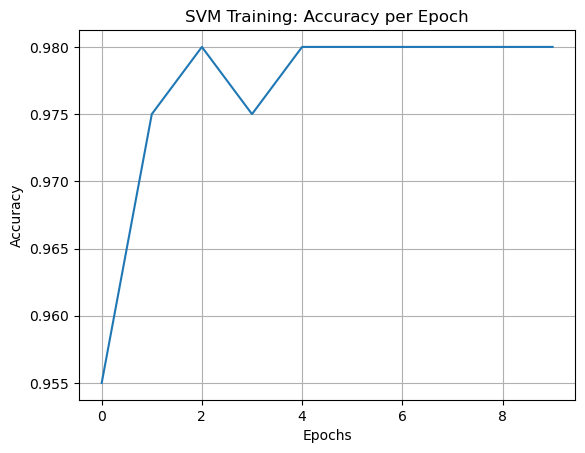

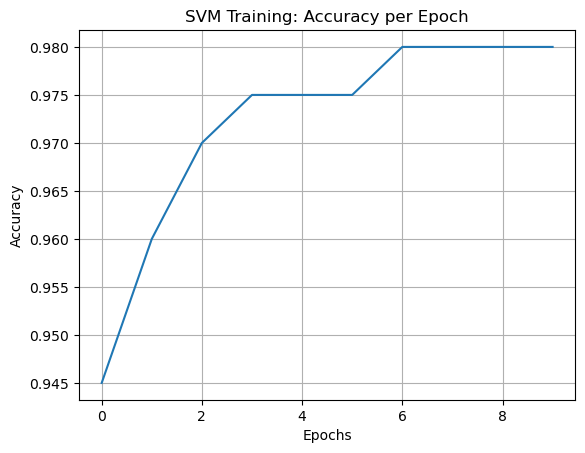

In [14]:
import numpy as np
import matplotlib.pyplot as plt

#duplicate of the function
def compute_accuracy(W, X, y):
    """ Computes the accuracy given the weights W, data X, and labels y. """
    predictions = np.sign(np.dot(X, W))
    return np.mean(predictions == y)

def train_svm_linear_print_epochs(X, y, batch_size=10, C=1.0, epochs=10, lr=0.01):
    w = np.random.randn(X.shape[1]) / np.sqrt(X.shape[1])  # Improved initialization
    n_batches = int(np.ceil(len(y) / batch_size))
    accuracies = []  # To store accuracies per epoch
    
    for epoch in range(epochs):
        perm = np.random.permutation(len(y))  # Shuffle the data
        for b in range(n_batches):
            start = b * batch_size
            end = min(start + batch_size, len(y))
            X_batch = X[perm[start:end]]
            y_batch = y[perm[start:end]]
            grad = svm_gradient(w, X_batch, y_batch, C)
            w -= lr * grad
            
        # Track accuracy after each epoch
        acc = compute_accuracy(w, X, y)
        accuracies.append(acc)
        
        # Optionally, decrease learning rate gradually
        if (epoch + 1) % 100 == 0:
            lr /= 2

    # Plot the accuracies over epochs
    plt.plot(range(epochs), accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('SVM Training: Accuracy per Epoch')
    plt.grid(True)
    plt.show()

    return w
def train_svm_adagra_with_plot(X, y, batch_size=10, C=1.0, epochs=10, lr=0.1):
    """
    Train a linear SVM using AdaGrad optimization.
    - X: feature matrix
    - y: target vector
    - batch_size: size of the mini-batch
    - C: regularization strength
    - epochs: number of training epochs
    - lr: initial learning rate
    """
    w = np.zeros(X.shape[1])
    epsilon = 1e-8  # smoothing term to avoid division by zero
    gradient_accumulate = np.zeros(X.shape[1])
    accuracies = []  # To store accuracies per epoch

    n_batches = int(np.ceil(len(y) / batch_size))
    for epoch in range(epochs):
        perm = np.random.permutation(len(y))  # Shuffle data each epoch
        for b in range(n_batches):
            start = b * batch_size
            end = min(start + batch_size, len(y))
            X_batch = X[perm[start:end]]
            y_batch = y[perm[start:end]]
            grad = svm_gradient(w, X_batch, y_batch, C)
            gradient_accumulate += grad ** 2
            adjusted_lr = lr / (epsilon + np.sqrt(gradient_accumulate))
            w -= adjusted_lr * grad

        # Track accuracy after each epoch
        acc = compute_accuracy(w, X, y)
        accuracies.append(acc)

    # Plot the accuracies over epochs
    plt.plot(range(epochs), accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('SVM Training: Accuracy per Epoch')
    plt.grid(True)
    plt.show()

    return w

X, y = load_dataset("toydata_tiny.csv")
trained_weights = train_svm_adagra_with_plot(X, y)
trained_weights = train_svm_linear_print_epochs(X, y)


In [ ]:
# Required imports
import itertools

# Example usage
datasets = {
    'toydate_tiny': load_dataset("toydata_tiny.csv"),
    'imdb': load_imdb_dataset(3000, 2)
}

model_types = ['rff']

# Defining parameter values
C_values = [0.1]
lr_values = [.1, 0.5, 1.0, 2]
batch_size_values = [50]
gamma_values = [0.1]
n_features_values = [100, 250, 500, 750, 1000, 2000]
epochs_values = [1]  # Added multiple values for epochs

# Creating parameter combinations for each model
params = {
    'linear': [
        {'C': C, 'epochs': epochs, 'lr': lr, 'batch_size': bs} 
        for C, epochs, lr, bs in itertools.product(C_values, epochs_values, lr_values, batch_size_values)
    ],
    'adagrad': [
        {'C': C, 'epochs': epochs, 'lr': lr, 'batch_size': bs} 
        for C, epochs, lr, bs in itertools.product(C_values, epochs_values, lr_values, batch_size_values)
    ],
    'rff': [
        {'C': C, 'epochs': epochs, 'lr': lr, 'batch_size': bs, 'gamma': g, 'n_features': nf} 
        for C, epochs, lr, bs, g, nf in itertools.product(C_values, epochs_values, lr_values, batch_size_values, gamma_values, n_features_values)
    ]
}

print(params)

results = evaluate_models_k_test(datasets, model_types, params)
print(results)


X shape:  (200, 2)
y shape:  (200,)


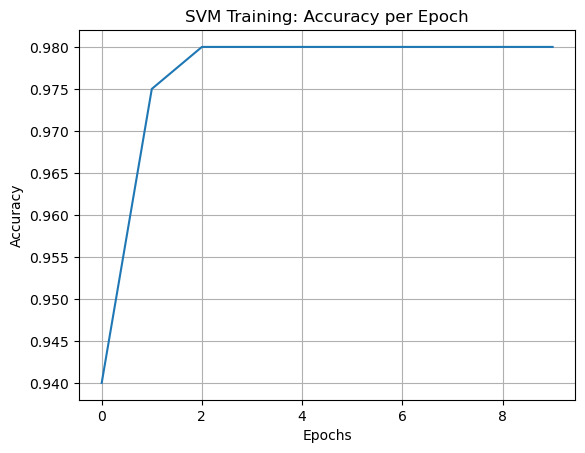

Time taken by Adagrad method: 0.23953676223754883 seconds


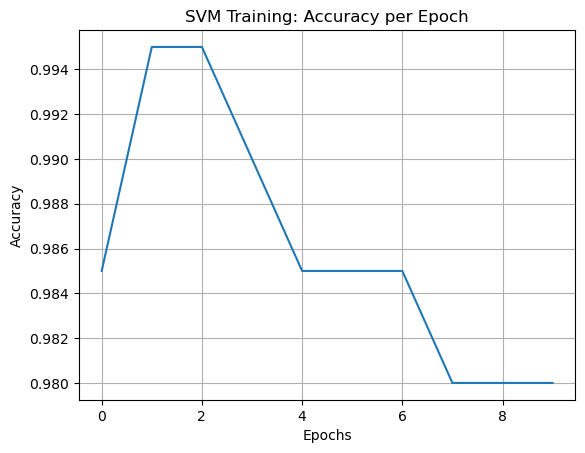

Time taken by linear SVM method: 0.20627593994140625 seconds


In [15]:
import time
# code to get the time of svms 
# hier muss man noch anpassen welche methoden man nimmt un die parameter
X, y = load_dataset("toydata_tiny.csv")

# Timing and training with Adagrad
start_time = time.time()
train_svm_adagra_with_plot(X, y)
end_time = time.time()
print(f"Time taken by Adagrad method: {end_time - start_time} seconds")

# Timing and training with linear SVM
start_time = time.time()
train_svm_linear_print_epochs(X, y)
end_time = time.time()
print(f"Time taken by linear SVM method: {end_time - start_time} seconds")